# Run Signal Injection Process

In [10]:
import astropy.io.fits as fits
import matplotlib.pylab as plt
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
import math
from mpmath import mp
import os
import os.path 
import random
from random import seed
from random import choice
from random import uniform
import mplcursors
import pandas as pd
%matplotlib inline

## Necessary Functions
First two functions cpied from Anna Zuckerman's Github repository: https://github.com/annazuckerman/specmatch-emp-apf

In [11]:
mp.dps=100
exp_array = np.frompyfunc(mp.exp, 1, 1)

# function to insert simulated gaussians by adding a gaussian into a given location in the spectrum
def insert_gaussian(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] + gauss
    return new_spect

# same as above, but REMOVES the part of the data where the gaussian is inserted
def insert_gaussian_with_data_removal(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = gauss
    return new_spect
    
def gaussian(x,a,b,c,d): # a = height, b = position of peak, c = width, x = numpy array of x values
    f = a*exp_array((-(x-b)**2)/(2*c)**2) + d
    return f 

def chi(model, data):
    '''given two arrays of the same length, calculate chi-squared'''
    return np.sum((data - model) ** 2)

## Set parameters

In [12]:
plot = False  # plt.show()
save_figs = False  # save figures into folders

inject_signals = True  # randomly inject signals into data that do not overlap
num_random_injections = 50  # number of injected signals

# for establishing threshold: T = m * n, where m is the median of the medians of pixels that exceed the continuum
n = 1.05

threshold_testing = True   # visualize which heights and widths go detected

only_test_certain_range = False  # whether or not to trucnate the spectra or run the algorithm on its entirety 
min_index = 0  # if truncating, which index to start at
max_index = 1000  # if truncating, which index to end at

plt.rcParams["figure.figsize"] = (5,3)
plt.rcParams.update({'font.size': 7})

# table containing all the stars and detections
column_names = ['star', 'index', 'ndetections']
total_detections = pd.DataFrame(columns = column_names)

seed = 11

## Read in Reduced Data from Anna Zuckerman's repo

In [13]:
plt.rcParams["figure.figsize"] = (18,12)
plt.rcParams.update({'font.size': 20})

directory = '/mnt_home/azuckerman/APF_spectra/NDR_corrected_wl_scale'

# every file in Anna's NDR_corrected_wl_scale folder
list_of_files = []
for filename in os.listdir(directory):
    if filename.endswith(".fits"): 
        file_path = os.path.join(directory, filename)
        list_of_files = np.append(list_of_files, file_path)

In [14]:
if threshold_testing == True:
    # injected signals information
    heights = []
    widths = []
    indicies = []
    wavelengths = []
    max_flux_vals = []
    
    # unrecovered signals information
    unrecovered_heights = []
    unrecovered_widths = []
    unrecovered_indicies = []
    unrecovered_wavelengths = []
    unrecovered_max_flux_vals = []
    
    # unrecovered signals that failed the width or gaussian test
    failed_unrecovered_heights = []
    failed_unrecovered_widths = []
    failed_unrecovered_indicies = []
    failed_unrecovered_wavelengths = []
    failed_unrecovered_max_flux_vals = []
    
    # recovered signals information
    recovered_widths = []
    recovered_heights = []
    recovered_indicies = []
    recovered_wavelengths = []
    recovered_max_flux_vals = []
    
    # uninjected detected signals information
    detected_widths = []
    detected_heights = []
    detected_indicies = []
    detected_wavelengths = []
    detected_max_flux_vals = []
    
    star_indicies = [] # which star in the list the other values correspond to
    threshold_vals = []
    
    num_injections = 0
    num_injections_above_threshold = 0
    num_recoveries = 0

In [15]:
# for which_star in np.arange(len(list_of_files)):

for which_star in np.arange(1):
    if threshold_testing == True:
    # injected signals information
        temp_heights = []
        temp_widths = []
        temp_indicies = []
        temp_wavelengths = []
        temp_max_flux_vals = []

        # unrecovered signals information
        temp_unrecovered_heights = []
        temp_unrecovered_widths = []
        temp_unrecovered_indicies = []
        temp_unrecovered_wavelengths = []
        temp_unrecovered_max_flux_vals = []

        # unrecovered signals that failed the width or gaussian test
        failed_unrecovered_heights = []
        failed_unrecovered_widths = []
        failed_unrecovered_indicies = []
        failed_unrecovered_wavelengths = []
        failed_unrecovered_max_flux_vals = []

        # recovered signals information
        temp_recovered_widths = []
        temp_recovered_heights = []
        temp_recovered_indicies = [] # only one needed
        temp_recovered_wavelengths = []
        temp_recovered_max_flux_vals = []

        # uninjected detected signals information
        detected_widths = []
        detected_heights = []
        detected_indicies = []
        detected_wavelengths = []
        detected_max_flux_vals = []

    

    # Choose one star from list of all stars
    APF_flux_path = list_of_files[which_star]

    file = fits.open(APF_flux_path)
    flux = file[0].data
    wl = file[1].data

    header = file[0].header
    star = header['OBJECT']

    print('File path: ' + APF_flux_path)
    print('Star: ' + star)
    
    num_detections_this_star = 0
    # table containing info about this observation
    column_names = ['description', 'indicies']
    detections = pd.DataFrame(columns = column_names)



    spect = flux

    if inject_signals == True:

        # inject random signals with no overlap
        interval = len(spect) / num_random_injections
        for i in np.arange(interval, len(spect), interval):

            random.seed(seed)
            random_val = random.choice(flux[int(i - interval + 30):int(i - 30)])
            location = flux.tolist().index(random_val)
            height = uniform(0.1, 0.3)
            width = uniform(0.5, 8)
            seed += 1

            if width > 8:
                position = 15
                numpoints = 30
            elif width > 5:
                position = 10
                numpoints = 20
            else:
                position = 5
                numpoints = 10
            
            star_indicies = np.append(star_indicies, which_star)
            num_injections += 1

            # create a copy of the spectra to insert PERFECT gaussians instead of adding the gaussians into the data
            # in order to calculate the pixel width of each inserted gaussian 
            copy_of_spect = spect[:]
            copy_of_spect = insert_gaussian_with_data_removal(copy_of_spect, [height, position, width, 1], location, numpoints)

            spect = insert_gaussian(spect,[height, position, width, 0], location, numpoints)
            heights = np.append(heights, height)
            temp_heights = np.append(temp_heights, height)

            # find maximum flux value of the inserted signal
            flux_vals = spect[location - int(numpoints / 2) : location + int(numpoints / 2)]
            max_flux_val = max(flux_vals)
            max_flux_vals = np.append(max_flux_vals, max_flux_val)
            temp_max_flux_vals = np.append(temp_max_flux_vals, max_flux_val)


            # find width of gaussian in pixels

            x = wl[location - int(numpoints / 2) : location + int(numpoints / 2)]
            y = copy_of_spect[location - int(numpoints / 2) : location + int(numpoints / 2)]

            oversampled_x = np.linspace(x[0], x[-1], len(x) * 1000)
            spl = splrep(x, y)
            oversampled_y = splev(oversampled_x, spl)

    #         plt.plot(x, y)
    #         plt.plot(oversampled_x, oversampled_y)
    #         for i in np.arange(-5, 5):
    #             plt.axvline(x=wl[location + i], color='gray', linestyle='--')

            peak = max(oversampled_y)
            half_max = peak - height / 2

            peak_index = oversampled_y.tolist().index(peak)
            temp_left_bound = peak_index
            temp_right_bound = peak_index

            while oversampled_y[temp_left_bound] > half_max and temp_left_bound > 0:
                temp_left_bound -=1

            while oversampled_y[temp_right_bound] > half_max and temp_right_bound < len(oversampled_y) - 1:
                temp_right_bound += 1

            pixel_width = (temp_right_bound - temp_left_bound) / 1000
    #         plt.title('Injected signal with pixel of ' + str(pixel_width))
    #         plt.show()

            widths = np.append(widths, pixel_width)
            indicies = np.append(indicies, location)
            wavelengths = np.append(wavelengths, wl[location])
            
            temp_widths = np.append(temp_widths, pixel_width)
            temp_indicies = np.append(temp_indicies, location)
            temp_wavelengths = np.append(temp_wavelengths, wl[location])

    if (plot == True) or (save_figs == True):
        fig = plt.figure()
        if inject_signals == True: 
            plt.plot(wl, spect, label = 'Injected Signals')
            plt.title('Original Data and Injected Signals')
        else:
            plt.title('Original Data')
            global_median = np.median(flux)
            global_SD = np.std(flux)
        plt.plot(wl, flux, label = 'Original Data')
        plt.xlabel('Wavelength [A]')
        plt.ylabel('Flux')
        plt.legend()
    if plot == True:
        plt.show()
    # if save_figs == True:
    #     path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/LaserDetectionResults/' + star
    #     if not (os.path.isdir(path)):
    #         os.mkdir(path)
    #     fig.savefig(path + '/' + star + '_injected_signals.png')

    idxs1 = [] # indicies that are above continuum level
    idxs2 = [] # indicies in idxs1 that are above the threshold value and are local maximas
    idxs3 = [] # indicies in idxs2 that are gaussian-shaped
    idxs4 = [] # indicies in idxs3 that are greater than 5 pixels in width

    continuum = np.percentile(spect, 95)

    for idx in np.arange(len(spect) - 2):
        # first test: create an array of all indices that are above the continuum level
        if spect[idx] > continuum:
            idxs1 = idxs1 + [idx]

    consecutive_indicies = []
    i = 0
    while i < (len(idxs1) - 1):
        list = [idxs1[i]]
        while i < len(idxs1) - 1 and idxs1[i + 1] == idxs1[i] + 1:
            list = np.append(list, idxs1[i+1])
            i += 1
        consecutive_indicies = consecutive_indicies + [list]
        i +=1

    median_flux_vals = []
    for idxs in consecutive_indicies:
        flux_vals = []
        for idx in idxs:
            flux_vals = np.append(flux_vals, spect[idx])
        median_flux = np.median(flux_vals)
        median_flux_vals = np.append(median_flux_vals, median_flux)

    m = np.median(median_flux_vals)

    print('m is: ' + str(m))

    # T = C + m * n

    T = m * n
    threshold_vals = np.append(threshold_vals, T)
    
    for idx in idxs1:
        if spect[idx] > T:
            idxs2 = idxs2 + [idx]
            
            
            
            
# ISSUE ABOVE HERE
    


    consecutive_indicies_idxs2 = []
    i = 0
    while i < (len(idxs2)):
        list = [idxs2[i]]
        while (i < len(idxs2) - 1) and (idxs2[i + 1] == idxs2[i] + 1):
            list = np.append(list, idxs2[i+1])
            i += 1
        consecutive_indicies_idxs2 = consecutive_indicies_idxs2 + [list]
        i +=1

    median_indicies = []
    for idxs in consecutive_indicies_idxs2:
        max_index = max(idxs, key=lambda i: spect[i])
        median_indicies = np.append(median_indicies, int(max_index))

    idxs2 = np.array(median_indicies, dtype=int)
    num_injections_above_threshold += len(idxs2)

    if (plot == True or save_figs == True) & (len(idxs2) > 0):
        fig = plt.figure()
        plt.plot(wl, spect, label = 'Injected Signals')
        plt.plot(wl, flux, label = 'Original Data')
        for ind in idxs2:
            plt.axvline(x=wl[ind], color='gray', linestyle='--')
        plt.axhline(y=T, linestyle='--', label='Threshold')
        plt.title('Test 2: Local Maxima and above Threshold')
        plt.xlabel('Wavelength [A]')
        plt.ylabel('Flux')
        plt.legend() 
        if plot == True:
            plt.show()
    #     if save_figs == True:
    #         path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/LaserDetectionResults/' + star
    #         if not (os.path.isdir(path)):
    #             os.mkdir(path)
    #         fig.savefig(path + '/' + star + 'test2.png')


    for idx in idxs2:
        # fit a gaussian to the peak, see if the width is greater than or equal to 2 pixels
        # see how much signal resembles a gaussian
        # if last test is commented out, ALSO check FWHM of gaussian

        # DETERMINING EDGES OF SIGNAL: mark edge when flux reaches a local minimum
        # PRO: can identify two signals together
        # CON: can't deal with noise in signal

        temp_ind = idx
        left_bound = 0
        while temp_ind > 1:
            temp_ind -= 1
            if spect[temp_ind] < spect[temp_ind - 1] and spect[temp_ind] < spect[temp_ind + 1]:
                left_bound = temp_ind
                break
        temp_ind = idx
        right_bound = len(spect) - 1
        while temp_ind < len(spect) - 4:
            temp_ind += 1
            if (spect[temp_ind] < spect[temp_ind - 1]) and (spect[temp_ind] < spect[temp_ind + 1]):
                right_bound = temp_ind
                break

        x = wl[left_bound:right_bound + 2]
        y = spect[left_bound:right_bound + 2]

        # oversample detected signal to determine precise bounds on the edges of the signal
        # use this to determine the FWHM of the signal in pixels
        oversampled_x = np.linspace(x[0], x[-1], len(x) * 10)
        spl = splrep(x, y)
        oversampled_y = splev(oversampled_x, spl)

        max_y = max(oversampled_y)
        min_y = np.percentile(oversampled_y, 3) 
        height = max_y - min_y
        ind = oversampled_y.tolist().index(max_y)
        pos = oversampled_x[ind]
        min_width = 0.00001
        max_width = oversampled_x[len(oversampled_x) - 1] - oversampled_x[0]
        width_spacing = 0.001

        chi_squared_values = []
        width_vals = np.arange(min_width, max_width, width_spacing)
        for w in width_vals:
            gaus = gaussian(oversampled_x, height, pos, w, min_y)
            chi_squared = chi(gaus, oversampled_y)
            chi_squared_values = np.append(chi_squared_values, chi_squared)
        min_chi_squared = min(chi_squared_values)
        ind_of_min_chisquared = chi_squared_values.tolist().index(min_chi_squared)
        width = width_vals[ind_of_min_chisquared]
        gaus = gaussian(oversampled_x, height, pos, width, min_y)

        width_threshold = False
        gauss_threshold = False

        # see if the signal fits a gaussian
        if min_chi_squared < 100000:
            gauss_threshold = True
            idxs3 = idxs3 + [idx]

            # find the width of the gaussian in pixels

            peak = max(gaus)
            half_max = peak - height / 2

            peak_index = gaus.tolist().index(peak)
            temp_left_bound = peak_index
            temp_right_bound = peak_index

            while gaus[temp_left_bound] > half_max and temp_left_bound > 0:
                temp_left_bound -=1

            while gaus[temp_right_bound] > half_max and temp_right_bound < len(gaus) - 1:
                temp_right_bound += 1

            pixel_width = (temp_right_bound - temp_left_bound) / 10

            if pixel_width > 2.7:
                width_threshold = True
                idxs4 = idxs4 + [idx]
                num_detections_this_star += 1

            else:
                failed_unrecovered_indicies = failed_unrecovered_indicies + [idx]
        else:
            failed_unrecovered_indicies = failed_unrecovered_indicies + [idx]

        if plot == True or save_figs == True:
            fig = plt.figure()
            plt.plot(x, y, label = 'Detected Signal at ' + str(round(wl[idx], 2)) + ' A')
            plt.plot(oversampled_x, gaus, label = 'Gaussian')
#             plt.scatter(oversampled_x[temp_left_bound], gaus[temp_left_bound], color = 'blue')
#             plt.scatter(oversampled_x[temp_right_bound], gaus[temp_right_bound], color = 'blue')
            if width_threshold == True:
                # passed width threshold AND gaussian threshold
                plt.title('PASS: chi-squared of ' + str(round(min_chi_squared, 4)) + ' and pixel width of ' + str(pixel_width))
            elif gauss_threshold == True and width_threshold == False:
                # failed width threshold
                plt.title('FAIL: too narrow with pixel width of ' + str(pixel_width))
            else:
                # failed gaussian threshold
                plt.title('FAIL: not gaussian-shaped: chi-squared of ' + str(round(min_chi_squared, 4)))

            plt.xlabel('Wavelength [A]')
            plt.ylabel('Flux')
            for ind in np.arange(left_bound - 2, right_bound + 3):
                plt.axvline(x=wl[ind], color='gray', linestyle='-', linewidth=0.2)
            plt.legend()
            if plot == True:
                plt.show()
            if save_figs == True:

                # comment out next lines if saving other figs and uncomment out bottom chunk
                path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/ThresholdTesting/'
                if not (os.path.isdir(path)):
                    os.mkdir(path)
                if not gauss_threshold:
                    fig.savefig(path + str(width) + '_' + str(max_flux_val) + '.png')




    #             test4_path = path + '/test4'
    #             if not (os.path.isdir(test4_path)):
    #                 os.mkdir(test4_path)
    #             pos_path = test4_path + '/pass'
    #             neg_path = test4_path + '/fail'
    #             if not (os.path.isdir(pos_path) and os.path.isdir(neg_path)):
    #                 os.mkdir(pos_path)
    #                 os.mkdir(neg_path)
    #             if passed:
    #                 fig.savefig(pos_path + '/test4' + '_' + str(round(wl[idx])) + '.png')
    #             else:
    #                 fig.savefig(neg_path + '/test4' + '_' + str(round(wl[idx])) + '.png')

    new1 = {'description': ['indicies above threshold', 'indicies that are gaussian-shaped', 'indicies wider than PSF'],
            'indicies': [idxs2, idxs3, idxs4]}
    df1 = pd.DataFrame(new1)
    detections = detections.append(df1)
    name = str(which_star) + '_' + star
    
    
    new2 = {'star': [star], 'index': [which_star], 'ndetections': [num_detections_this_star]}
    df2 = pd.DataFrame(new2)
    total_detections = total_detections.append(df2)

    if threshold_testing == True:
    
        for idx in idxs4:    
            absolute_difference_function = lambda list_value : abs(list_value - idx)
            i = min(temp_indicies.tolist(), key = absolute_difference_function)
            index = temp_indicies.tolist().index(i)
            if abs(idx - temp_indicies[index]) < 4 and (temp_indicies[index] not in temp_recovered_indicies):
                # add to recovered signals information
                temp_recovered_indicies = np.append(temp_recovered_indicies, temp_indicies[index])
                temp_recovered_heights = np.append(temp_recovered_heights, temp_heights[index])
                temp_recovered_widths = np.append(temp_recovered_widths, temp_widths[index])
                temp_recovered_max_flux_vals = np.append(temp_recovered_max_flux_vals, temp_max_flux_vals[index])
            else:
                detected_widths = np.append(detected_widths, temp_widths[index])
                detected_heights = np.append(detected_heights, temp_heights[index])
                detected_indicies = np.append(detected_indicies, temp_indicies[index])
    #             detected_wavelengths = np.append(detected_wavelengths, wl[index])
                detected_max_flux_vals = np.append(detected_max_flux_vals, temp_max_flux_vals[index])
        recovered_indicies = np.append(recovered_indicies, temp_recovered_indicies)
        num_recoveries += len(recovered_indicies)
        
        recovered_heights = np.append(recovered_heights, temp_recovered_heights)
        recovered_widths = np.append(recovered_widths, temp_recovered_widths)
        recovered_max_flux_vals = np.append(recovered_max_flux_vals, temp_recovered_max_flux_vals)
       
    # create a list of failed indicies due to failing the gaussian or width test
        for idx in failed_unrecovered_indicies:  
            i = min(indicies.tolist(), key = absolute_difference_function)
            index = indicies.tolist().index(i)
            if abs(idx - indicies[index]) < 4:
                # add to failed signals information
                failed_unrecovered_widths = np.append(failed_unrecovered_widths, widths[index])
                failed_unrecovered_heights = np.append(failed_unrecovered_heights, heights[index])
                failed_unrecovered_indicies = np.append(failed_unrecovered_indicies, indicies[index])
                failed_unrecovered_wavelengths = np.append(failed_unrecovered_wavelengths, wavelengths[index])
                failed_unrecovered_max_flux_vals = np.append(failed_unrecovered_max_flux_vals, max_flux_vals[index])


        temporary_unrecovered_widths = temp_widths[:]
        for i in temp_recovered_widths:
            if i in temporary_unrecovered_widths:
                index_to_remove = temporary_unrecovered_widths.tolist().index(i)
                temporary_unrecovered_widths = np.delete(temporary_unrecovered_widths, index_to_remove)
        unrecovered_widths = np.append(unrecovered_widths, temporary_unrecovered_widths)

        temporary_unrecovered_heights = temp_heights[:]
        for i in temp_recovered_heights:
            if i in temporary_unrecovered_heights:
                index_to_remove = temporary_unrecovered_heights.tolist().index(i)
                temporary_unrecovered_heights = np.delete(temporary_unrecovered_heights, index_to_remove)
        unrecovered_heights = np.append(unrecovered_heights, temporary_unrecovered_heights)

        temporary_unrecovered_max_flux_vals = temp_max_flux_vals[:]
        for i in temp_recovered_max_flux_vals:
            if i in temporary_unrecovered_max_flux_vals:
                index_to_remove = temporary_unrecovered_max_flux_vals.tolist().index(i)
                temporary_unrecovered_max_flux_vals = np.delete(temporary_unrecovered_max_flux_vals, index_to_remove)
        unrecovered_max_flux_vals = np.append(unrecovered_max_flux_vals, temporary_unrecovered_max_flux_vals)
        

File path: /mnt_home/azuckerman/APF_spectra/NDR_corrected_wl_scale/ramq.233.NDR.fits
Star: HIP12444
m is: 1.0054114202492042


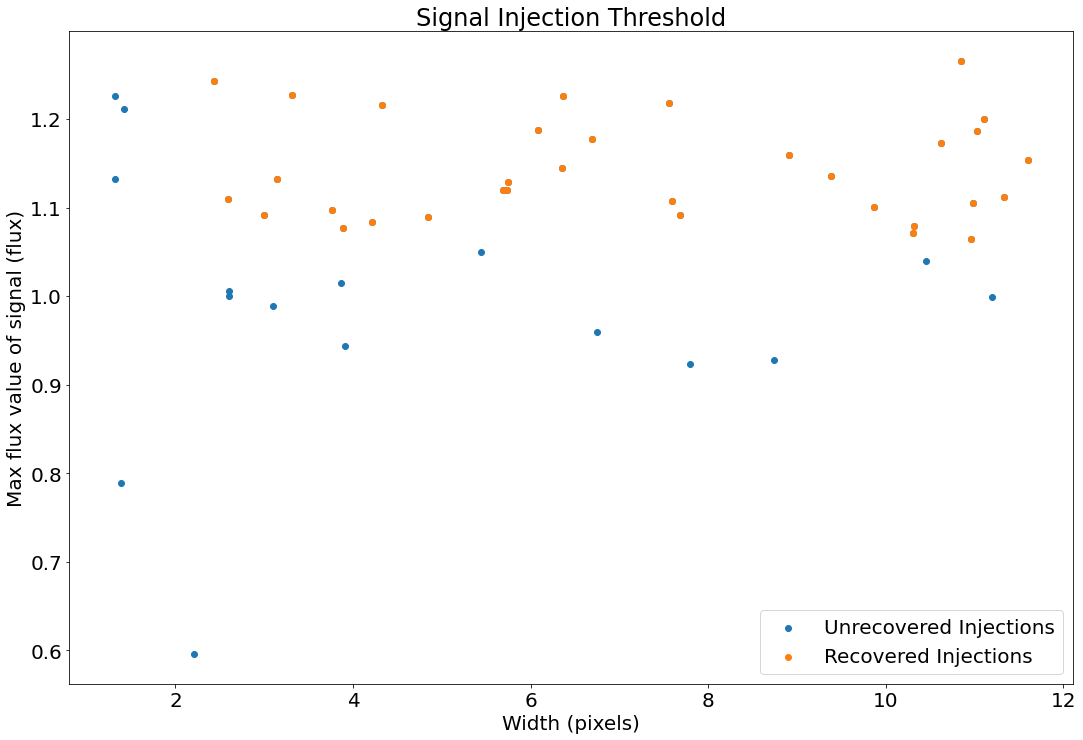

In [16]:

fig = plt.figure()
plt.scatter(widths, max_flux_vals, label = 'Unrecovered Injections')
# plt.scatter(unrecovered_widths, unrecovered_max_flux_vals, label = 'Unrecovered Injections') 
plt.scatter(recovered_widths, recovered_max_flux_vals, label = 'Recovered Injections')
# plt.scatter(detected_widths, detected_max_flux_vals, label = 'Uninjected Detections')

plt.xlabel('Width (pixels)')
plt.ylabel('Max flux value of signal (flux)')
plt.title('Signal Injection Threshold')
plt.legend()
plt.show()

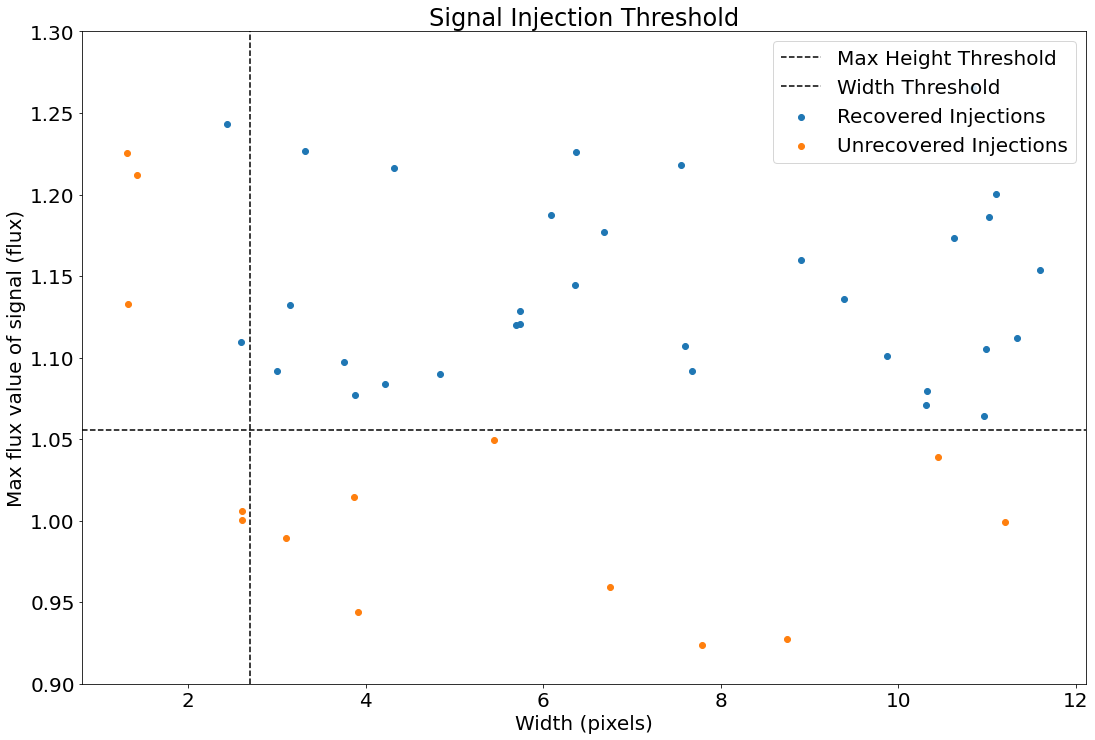

In [17]:
fig = plt.figure()
plt.scatter(recovered_widths, recovered_max_flux_vals, label = 'Recovered Injections')
plt.scatter(unrecovered_widths, unrecovered_max_flux_vals, label = 'Unrecovered Injections') 

# plt.scatter(detected_widths, detected_max_flux_vals, label = 'Uninjected Detections')
# plt.scatter(failed_unrecovered_widths, failed_unrecovered_max_flux_vals, label = 'Unrecovered Injections that failed the width/gaussian test')


plt.xlabel('Width (pixels)')
plt.ylabel('Max flux value of signal (flux)')
plt.title('Signal Injection Threshold')

plt.axhline(y=max(threshold_vals), linestyle='--', c='black', label='Max Height Threshold')
plt.axvline(x=2.7, linestyle='--', c='black', label='Width Threshold')
    
plt.ylim(0.9, 1.3)
plt.legend()
plt.show()


# fig = plt.figure()
# plt.scatter(widths, max_flux_vals, label = 'Unrecovered Injections') 
# plt.scatter(recovered_widths, recovered_max_flux_vals, label = 'Recovered Injections')
# plt.scatter(detected_widths, detected_max_flux_vals, label = 'Uninjected Detections')

# plt.xlabel('Width (pixels)')
# plt.ylabel('Max flux value of signal (flux)')
# plt.title('Signal Injection Threshold')
# plt.legend()
# plt.show()


In [18]:
print(max(threshold_vals))

1.0556819912616644


In [19]:
detections

,description,indicies
0,indicies above threshold,"[2200, 5501, 6317, 8193, 9529, 11888, 11893, 1..."
1,indicies that are gaussian-shaped,"[2200, 5501, 6317, 8193, 9529, 11888, 11893, 1..."
2,indicies wider than PSF,"[2200, 5501, 9529, 11888, 11893, 14258, 17852,..."


In [20]:
total_detections

,star,index,ndetections
0,HIP12444,0,34
